In [1]:
import import_ipynb
from maze_common import *
import time
import random as rnd
import numpy as np
import copy
import matplotlib.pyplot as plt

importing Jupyter notebook from maze_common.ipynb


Generate a maze.

In [2]:
maze = Maze(60, .30)
solvable = maze.isSolvable()
print("Is solvable?", solvable)
print("Obstacles?", maze.obstacles.shape[0])

Is solvable? True
Obstacles? 1066


If the maze is solvable, find the shortest path *without* a heuristic function (i.e. uniform cost search).

In [ ]:
if (solvable):
    shortestPath, expandedCells = shortestPathSearch(maze)
    print("Expanded cells:", expandedCells)
    print("Shortest path length:", len(shortestPath), "\nShortest path:", shortestPath)
    for coords in shortestPath:
        row, col = coords
        if (maze.board[row, col] == -1):
            print("Error")

Define a heuristic that employs the Manhattan distance formula.

In [3]:
def manhattanDistance(cell, maze, visited):
    cellRow, cellCol = cell.coords
    return ((maze.dim - 1) - cellRow) + ((maze.dim - 1) - cellCol)

Test the Manhattan distance heuristic, and ensure the shortest path is valid and has length less than or equal to that of the original shortest path.

In [ ]:
if (solvable):
    startTime = time.time()
    shortestPath, expandedCells = shortestPathSearch(maze, heuristicFunction = manhattanDistance)
    print("Expanded cells:", expandedCells)
    print("Shortest path length:", len(shortestPath), "\nShortest path:", shortestPath)
    for coords in shortestPath:
        row, col = coords
        if (maze.board[row, col] == -1):
            print("Error")

Define a function for thinning a maze. Given the maze and a fraction of obstacles to remove, create a copy of the maze that has a reduced number of obstacles.

In [4]:
def thinMaze(maze, fractionRemove):
    thinMaze = copy.deepcopy(maze)
    # Choose how many obstacles to remove. This value is rounded to the nearest integer.
    numRemove = int(round(fractionRemove * thinMaze.obstacles.shape[0]))
    for i in range(0, numRemove):
        # Choose a random obstacle to remove by choosing a random index in the thinned maze's obstacle array.
        indexRemove = int(rnd.random() * thinMaze.obstacles.shape[0])
        obstacleX, obstacleY = thinMaze.obstacles[indexRemove]
        # Remove the chosen obstacle from the thinned maze's obstacle array.
        thinMaze.obstacles = np.delete(thinMaze.obstacles, indexRemove, axis=0)
        # Update the thinned maze's board to open up the previously blocked position.
        thinMaze.board[obstacleX, obstacleY] = Cell.OPEN
    return thinMaze
    
thinnedMaze = thinMaze(maze, .5)
print("Original obstacles: ", maze.obstacles.shape[0])
print("Thinned obstacles: ", thinnedMaze.obstacles.shape[0])

Original obstacles:  1066
Thinned obstacles:  533


Define a heuristic that finds the shortest path from the given coordinates to the goal in the thinned maze. This heuristic will simply use a uniform cost path search in the thinned maze from the given coordinates to the goal, and it has access to a dictionary of already-discovered heuristics that prevents redoing the heuristic for cells that have already been passed to this function. This `visited` dictionary is valid because the heuristic score should never change for a given cell, since the maze utilized is static.

In [8]:
def thinnedMazeShortestPathLength(cell, maze, visited):
    cellRow, cellCol = cell.coords
    shortestPathLength = 0
    if ((cellRow, cellCol)) not in visited:
        shortestPath, ignoredExpandedCellsBySearch = shortestPathSearch(thinnedMaze, startCoords = (cellRow, cellCol))
        shortestPathLength = len(shortestPath)       
        for i in range(0, shortestPathLength):
            row, col = shortestPath[i]
            if ((row, col)) in visited: 
                break
            else:
                visited[(row, col)] = shortestPathLength - i - 1
    else:
        shortestPathLength = visited[(cellRow, cellCol)]
    return shortestPathLength

Test the thinned maze heuristic, and ensure the shortest path is valid and has length less than or equal to that of the original shortest path.

In [ ]:
if (solvable):
    startTime = time.time()
    shortestPath, expandedCells = shortestPathSearch(maze, heuristicFunction = thinnedMazeShortestPathLength)
    print("Time:", time.time() - startTime, "seconds")
    print("Expanded cells:", expandedCells)
    print("Shortest path length:", len(shortestPath), "\nShortest path:", shortestPath)
    for coords in shortestPath:
        row, col = coords
        if (maze.board[row, col] == -1):
            print("Error")

Define a new function for finding neighboring cells. This function builds upon the `findNeighboringCoords` function defined in `maze_common.ipynb`. In addition to finding open cells above, below, and to the side of the given coordinates, this function also finds the diagonal open neighbors of the cell.

In [5]:
def findNeighboringOpenCoordsIncludingDiagonals(coords, maze):
    cellRow, cellCol = coords
    neighbors = findNeighboringOpenCoords(coords, maze)
    potentialDiagonalNeighbors = [(cellRow - 1, cellCol - 1), (cellRow - 1, cellCol + 1), (cellRow + 1, cellCol - 1), (cellRow + 1, cellCol + 1)]
    for potentialDiagonalNeighbor in potentialDiagonalNeighbors:
        row, col = potentialDiagonalNeighbor
        if (row >= maze.dim or row < 0 or col >= maze.dim or col < 0 or maze.board[row,col] != Cell.OPEN):
            continue
        neighbors.append((row, col))
    return neighbors

Define a heuristic that finds the shortest path from the given coordinates to the goal in the original maze with the "enhanced" `findNeighbors` function that takes into account diagonal neighbors as well. This heuristic will simply use a uniform cost path search in the maze from the given coordinates to the goal, and it has access to a dictionary of already-discovered heuristics that prevents redoing the heuristic for cells that have already been passed to this function. This `visited` dictionary is valid because the heuristic score should never change for a given cell, since the maze utilized is static.

In [6]:
def diagonalTravelShortestPathLength(cell, maze, visited):
    cellRow, cellCol = cell.coords 
    shortestPathLength = 0
    if ((cellRow, cellCol)) not in visited:
        shortestPath, ignoredExpandedCellsBySearch = shortestPathSearch(maze, startCoords = (cellRow, cellCol), findNeighborsFunction = findNeighboringOpenCoordsIncludingDiagonals)
        shortestPathLength = len(shortestPath)
        for i in range(0, shortestPathLength):
            row, col = shortestPath[i]
            if ((row, col)) in visited: 
                break
            else:
                visited[(row, col)] = shortestPathLength - i - 1
    else:
        shortestPathLength = visited[(cellRow, cellCol)]
    return shortestPathLength

Test the diagonal travel heuristic, and ensure the shortest path is valid and has length less than or equal to that of the original shortest path.

In [ ]:
if (solvable):
    startTime = time.time()
    shortestPath, expandedCells = shortestPathSearch(maze, heuristicFunction = diagonalTravelShortestPathLength)
    print("Expanded cells:", expandedCells)
    print("Shortest path length:", len(shortestPath), "\nShortest path:", shortestPath)
    boardWithPath = copy.deepcopy(maze.board)
    for coords in shortestPath:
        row, col = coords
        if (maze.board[row, col] == -1):
            print("Error")

Perform testing for all 3 previously defined heuristics.

In [ ]:
p = 0.3
dim = 50

iterationsPerRho = 100
rhos = np.arange(0.05, 1, 0.1)

manhattanDistanceExpandedCells = np.zeros([rhos.size, iterationsPerRho])
manhattanDistanceTimeCosts = np.zeros([rhos.size, iterationsPerRho])
thinnedMazeExpandedCells = np.zeros([rhos.size, iterationsPerRho])
thinnedMazeTimeCosts = np.zeros([rhos.size, iterationsPerRho])
diagonalTravelExpandedCells = np.zeros([rhos.size, iterationsPerRho])
diagonalTravelTimeCosts = np.zeros([rhos.size, iterationsPerRho])

testStartTime = time.time()

for i in range(0, rhos.size):
    rho = rhos[i]
    
    for j in range(0, iterationsPerRho):
        maze = Maze(dim, p)
        while not maze.isSolvable():
            maze = Maze(dim, p)
        openCells = maze.dim**2 - maze.obstacles.shape[0]
        
        startTime = time.time()
        shortestPath, expandedCells = shortestPathSearch(maze, heuristicFunction = manhattanDistance)
        endTime = time.time() - startTime
        manhattanDistanceExpandedCells[i, j] = expandedCells / openCells
        manhattanDistanceTimeCosts[i, j] = endTime
        
        thinnedMaze = thinMaze(maze, rho)
        startTime = time.time()
        shortestPath, expandedCells = shortestPathSearch(maze, heuristicFunction = thinnedMazeShortestPathLength)
        endTime = time.time() - startTime
        thinnedMazeExpandedCells[i, j] = expandedCells / openCells
        thinnedMazeTimeCosts[i, j] = endTime
        
        startTime = time.time()
        shortestPath, expandedCells = shortestPathSearch(maze, heuristicFunction = diagonalTravelShortestPathLength)
        endTime = time.time() - startTime
        diagonalTravelExpandedCells[i, j] = expandedCells / openCells
        diagonalTravelTimeCosts[i, j] = endTime
        
manhattanDistanceAvgExpandedCells = np.mean(manhattanDistanceExpandedCells)
manhattanDistanceAvgTimeCost = np.mean(manhattanDistanceTimeCosts)
diagonalTravelAvgExpandedCells = np.mean(diagonalTravelExpandedCells)
diagonalTravelAvgTimeCost = np.mean(diagonalTravelTimeCosts)

thinnedMazeAvgExpandedCells = np.zeros([rhos.size])
thinnedMazeAvgTimeCosts = np.zeros([rhos.size])
for i in range(0, rhos.size):
    thinnedMazeAvgExpandedCells[i] = np.mean(thinnedMazeExpandedCells[i])
    thinnedMazeAvgTimeCosts = np.mean(thinnedMazeTimeCosts[i])

print("**Testing took", time.time() - testStartTime, "seconds to complete.**")
print("Manhattan Distance Avg Expanded Cells:", manhattanDistanceAvgExpandedCells)
print("Manhattan Distance Avg Time Cost:", manhattanDistanceAvgTimeCost)
print("Thinned Maze Avg Expanded Cells:", thinnedMazeAvgExpandedCells)
print("Thinned Maze Avg Time Costs:", thinnedMazeAvgTimeCosts)
print("Diagonal Travel Avg Expanded Cells:", diagonalTravelAvgExpandedCells)
print("Diagonal Travel Avg Time Cost:", diagonalTravelAvgTimeCost)


Generate the plots for the expanded cells (as a fraction of open cells).

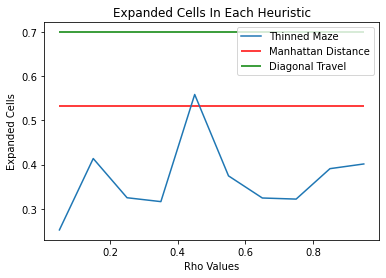

In [14]:
plt.figure()
plt.hlines(manhattanDistanceAvgExpandedCells, np.amin(rhos), np.amax(rhos), color="red", label="Manhattan Distance")
plt.plot(rhos, thinnedMazeAvgExpandedCells, label="Thinned Maze")
plt.hlines(diagonalTravelAvgExpandedCells, np.amin(rhos), np.amax(rhos), color="green", label="Diagonal Travel")
plt.xlabel("Rho Values")
plt.ylabel("Expanded Cells")
plt.title("Expanded Cells In Each Heuristic")
plt.legend(loc="best")
plt.show()